The purpose of this notebook is to get you started thinking about EMD, and using the python `emd` package (https://emd.readthedocs.io/en/stable/emd_tutorials/00_quick_start/emd_tutorial_00_start_01_quicksift.html)

## Import necessary packages

In [1]:
from utils.data_utils import lagged_matrix
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from scipy.stats import pearsonr
import emd

# Load EEG and stimulus data

We are going to fit a forward model for one of the participants. We are going to load and concatenate all 15 story parts for that participants

In [2]:
participant = 9# there are 13 participants in total

with h5py.File('../data/data.h5') as f:
    train_eeg = [f[f'eeg/P0{participant}/part{i}'][:].T for i in range(9)]
    train_env = [f[f'stim/part{i}'][:] for i in range(9)]
    
    test_eeg = [f[f'eeg/P0{participant}/part{i}'][:].T for i in range(9,15)]
    test_env = [f[f'stim/part{i}'][:] for i in range(9,15)]
    
    
train_eeg = np.vstack(train_eeg)
train_env = np.hstack(train_env)[:, np.newaxis]
    
test_eeg = np.vstack(test_eeg)
test_env = np.hstack(test_env)[:, np.newaxis]

Perform empirical mode decomposition on the envelopes. This process decomposes the train envelope into 12 IMFs (intrinsic moment functions):

In [3]:
train_imf = emd.sift.sift(train_env)
test_imf = emd.sift.sift(test_env)
print(train_imf.shape)

(185387, 12)


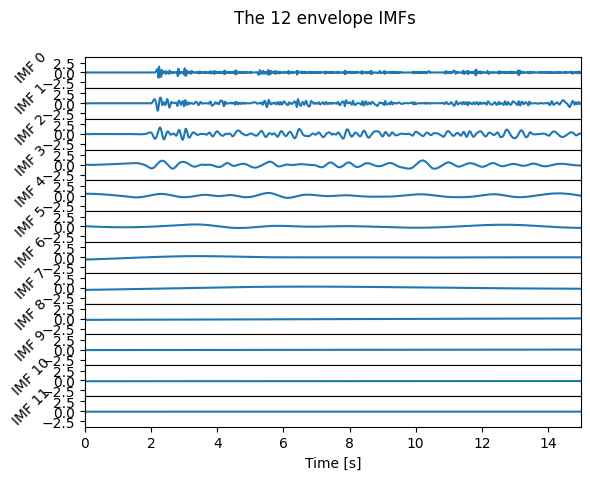

In [4]:
t = np.arange(len(train_env))/125

fig = plt.figure()
gs = fig.add_gridspec(12, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

fig.suptitle('The 12 envelope IMFs')

for i in range(12):
    axs[i].plot(t, train_imf[:, i])
    axs[i].set_xlim(0,15)
    axs[i].set_ylabel(f'IMF {i}', rotation=45)

axs[-1].set_xlabel('Time [s]')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

EMD has a filterbank property: the IMFs naturally exhibit different frequency bands

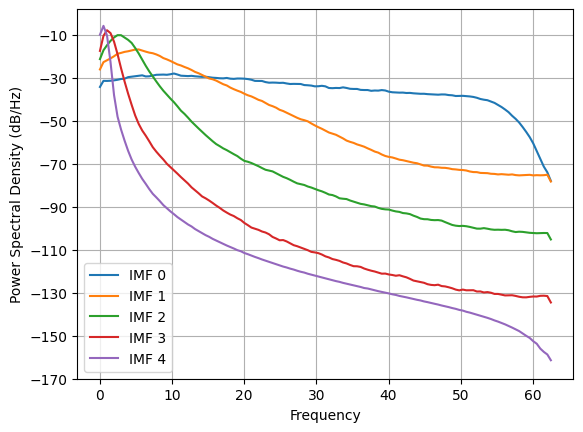

In [5]:
for i in range(5):
    plt.psd(train_imf[:,i], Fs=125, label=f'IMF {i}')
    
plt.legend()

# Fit forward models using the IMFs

In [6]:
imf = 4

env_lags = np.arange(-20, 50)
train_imf_lagged = lagged_matrix(train_imf[:, imf, None], env_lags)
test_imf_lagged = lagged_matrix(test_imf[:, imf, None], env_lags)

Now we will fit the ridge regression and look at how well each channel was reconstructed:

In [7]:
mdl = Ridge(alpha=1e3)
mdl.fit(train_imf_lagged, train_eeg)

predictions = mdl.predict(test_imf_lagged)

# plot the coefficients of the linear model:

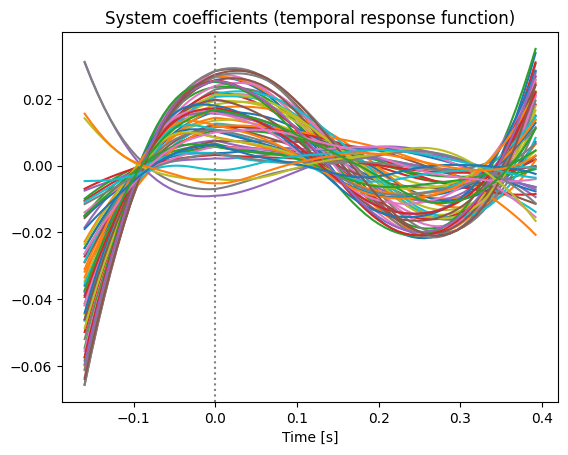

In [8]:
plt.plot(env_lags/125,mdl.coef_.T);
plt.title('System coefficients (temporal response function)')
plt.xlabel('Time [s]')
plt.axvline(0, color='grey', linestyle='dotted')

# Fit a backward model

In [9]:
eeg_lags = np.arange(-50, 20)
train_eeg_lagged = lagged_matrix(train_eeg, eeg_lags)
test_eeg_lagged = lagged_matrix(test_eeg, eeg_lags)

In [10]:
backward_mdl = Ridge(alpha=1e3)
backward_mdl.fit(train_eeg_lagged, train_imf[:, imf, None])

Ridge(alpha=1000.0)

In [11]:
predictions = backward_mdl.predict(test_eeg_lagged)
print(pearsonr(predictions.squeeze(), test_imf[:, imf].squeeze())[0])

0.41436320461486426
